[66 使用注意力机制的seq2seq](https://www.bilibili.com/video/BV1v44y1C7Tg?spm_id_from=333.999.0.0&vd_source=1d3a7b81d826789081d8b6870d4fff8e)
<img src="picture/截屏2022-06-22 20.15.52.png">

沐神解释了半天:总归原因可能就是以下几点
1. 从翻译的角度来说, 单词与单词是一一对应的, 我们人类翻译的时候, 一般是一个单词一个单词翻译, 同时会结合上下文的语气等等
2. 但是对于之前是seq2seq来说,  模型不会去关注某个重点单词, 输入整体被转换成隐藏层了, 实际上作为真正输入的只有最后一个单词(不是特别理解这句话,但大概是这么个意思)
3. 

<img src="picture/截屏2022-06-22 20.38.38.png">

- 个人理解, 之前的encoder的隐藏层和输出层整体都作为输入传输给了decoder, 但这样会导致新的问题, 就是信息都被隐藏了起来，这会导致解码器更难以学习更多的有效信息。
- 采用注意力机制能够使得隐藏的信息更有效的挖掘出来，因此我们可以在此理念上进行改进
- 

In [16]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional

这些貌似都是规定好的写法，这里只能硬记下来了

In [17]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [18]:
class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers,
        #                   dropout=dropout)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

In [19]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.

    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [20]:

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return functional.softmax(X.reshape(shape), dim=-1)

In [21]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [22]:
class AttentionDecoder(Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    # 这个有没有无所谓,主要是用来绘制图像使用
    def attention_weights(self):
        raise NotImplementedError

In [23]:
class AdditiveAttention(nn.Module):
    """Additive attention.

    Defined in :numref:`sec_attention-scoring-functions`"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

前面这些都是讲过的

```python
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state
```

In [24]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 新增加attention层
        # 这里非常粗暴的让k:q键值对全部用隐藏层来代替
        self.attention = AdditiveAttention(key_size=num_hiddens,
                                           query_size= num_hiddens, 
                                           num_hiddens = num_hiddens, 
                                           dropout=dropout)

        # 此部分依旧和之前的seq2seq相同
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        # self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """
        outputs的形状为(batch_size，num_steps，num_hiddens).
        hidden_state的形状为(num_layers，batch_size，num_hiddens)
        """
        outputs, hidden_state = enc_outputs
        return outputs.permute(1, 0, 2), hidden_state, enc_valid_lens

    def forward(self, X, state):
        """
        enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        hidden_state的形状为(num_layers,batch_size, num_hiddens)
        """
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        # 每次输入的context会发生变化，所以输入
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)，此部分来自上一层最后时刻的输出
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

与之前的seq2seq对比
可以看出主要区别就在于context的变化，不是简单大把隐藏层全部拿过来就完事了

```python
X = self.embedding(X).permute(1, 0, 2)
context = state[-1].repeat(X.shape[0], 1, 1)
X_and_context = torch.cat((X, context), 2)
output, state = self.rnn(X_and_context, state)
output = self.dense(output).permute(1, 0, 2)
```

核心代码部分
- <img src="picture/截屏2022-06-22 20.38.38.png" width="900" height="600">

```python
query = torch.unsqueeze(hidden_state[-1], dim=1)
context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1))
out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
outputs.append(out)
self._attention_weights.append(self.attention.attention_weights)
```

query:embedding的隐藏层，是上一次训练的隐藏层的最后一个时刻
按照init的定义，这里q和k都是来自于隐藏层的参数，后面看怎么写的
原x基础上加入context作为全新输入，这点和之前解码没有区别。

In [25]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [26]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

loss 0.020, 12123.4 tokens/sec on cuda:0


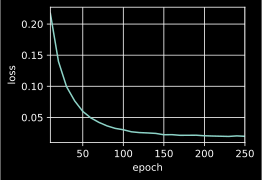

In [27]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [28]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est <unk> .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [29]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

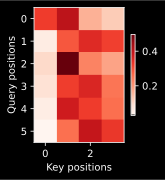

In [30]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

此部分还是有一点难度的，是前面的集大成之作，基本上把目前为止学过的nlp技术全部串联起来了
涉及如下几个方面：
1. 数据预处理知识，对于token的理解、<aos><eos><pad>的理解，循环中止条件，vaild_lens的概念以及其为什么会用于注意力机制
2. RNN基本知识，现有的rnn、lstm、GRU这些网络与经典网络的区别，以及隐藏层如何通过门控单元来转变成LSTM、GRU（实际上rnn可理解为一个全为1的门控单元，GRU、LSTM本质上只是门控单元的变化）
3. 解码器编码器知识，解码器与编码器之间是如何传递参数的，如何作为一个整体去训练
4. 注意力机制无法就是在解码器和编码器之间传参的时候做文章，通过将上一次训练的隐藏层作为注意力来作用于编码器解码器的传输。